In [1]:
import re
from dataclasses import dataclass 
from pathlib import Path
import datetime
import enum
from typing import Optional, List, Dict, Any, Generic, TypeVar, Callable, Tuple
T = TypeVar('T')

In [2]:
class RecordType(enum.Enum):
    ALLOCATION = 1
    RECYCLE = 2
    
@dataclass
class RecordPos:
    timestamp: datetime.datetime
    rank: int
    pid: int
    tid: int

class BufferPos(enum.Enum):
    MEMORY_CPU = 0
    MEMORY_CPU_PINNED = 1
    MEMORY_GPU = 2

@dataclass
class BufferInfo:
    pointer: int
    size: int = 0
    where: BufferPos = BufferPos.MEMORY_CPU
    tag: str = ""
    trace_id: int = 0

@dataclass
class Record:
    pos: RecordPos
    type: RecordType
    info: BufferInfo

@dataclass
class SpanRecord:
    start: Optional[RecordPos]
    end: Optional[RecordPos]
    info: BufferInfo

@dataclass
class CounterRecord(Generic[T]):
    timestamp: datetime.datetime
    value: int
    info: T

In [3]:
record_prefix = r'\[(?P<timestamp>[^\]]+)\] \[[^\]]+\] \[(?P<pid>\d+):(?P<tid>\d+)\] \[RANK (?P<rank>\d+)\]\[[^\]]+\]\[[^\]]+\]\[[^\]]+\] '
allocation_record_log = r'record allocation: (?P<pointer>0x[0-9a-fA-F]+), size: (?P<size>\d+), where: (?P<where>\d+), tag: \[(?P<tag>[^\]]*)\], trace id \[(?P<trace_id>\d+)\]'
allocation_record_regex = re.compile(rf'{record_prefix}{allocation_record_log}')
recycle_record_log = r'record recycle: (?P<pointer>0x[0-9a-fA-F]+) \[(?P<tag>[^\]]*)\]'
recycle_record_regex = re.compile(rf'{record_prefix}{recycle_record_log}')

def parse_record_pos(matched_res: re.Match[str]) -> Optional[RecordPos]:
    return RecordPos(
        timestamp=datetime.datetime.strptime(matched_res['timestamp'], "%Y-%m-%d %H:%M:%S.%f"),
        rank=int(matched_res['rank']),
        pid=int(matched_res['pid']),
        tid=int(matched_res['tid']),
    )

def parse_record(record_str: str) -> Optional[Record]:
    if 'record allocation' in record_str:
        matched_res = allocation_record_regex.match(record_str)
        if matched_res is None:
            return None
        record_pos = parse_record_pos(matched_res)
        buffer_info = BufferInfo(
            pointer=int(matched_res['pointer'], base=16),
            size=int(matched_res['size']),
            where=BufferPos(int(matched_res['where'])),
            tag=matched_res['tag'],
            trace_id=int(matched_res['trace_id'])
        )
        return Record(
            pos=record_pos,
            type=RecordType.ALLOCATION,
            info=buffer_info
        )
    elif 'record recycle' in record_str:
        matched_res = recycle_record_regex.match(record_str)
        if matched_res is None:
            return None
        record_pos = parse_record_pos(matched_res)
        buffer_info = BufferInfo(
            pointer=int(matched_res['pointer'], base=16),
            tag=matched_res['tag']
        )
        return Record(
            pos=record_pos,
            type=RecordType.RECYCLE,
            info=buffer_info
        )
    else:
        return None

In [4]:
def load_records(path: str) -> List[Record]:
    with Path(path).open('r') as f:
        state = {}
        res = []
        for line in f:
            record = parse_record(line)
            if record is not None:
                if record.type == RecordType.ALLOCATION:
                    state[record.info.pointer] = record.info
                elif record.type == RecordType.RECYCLE:
                    info = state.pop(record.info.pointer, None)
                    if info is not None:
                        record.info = info
                res.append(record)
        return res

def measure_records(records: List[Record]):
    start_time = None
    end_time = None
    start_addr = None
    end_addr = None
    for record in records:
        timestamp = record.pos.timestamp
        if start_time is None or start_time > timestamp:
            start_time = timestamp
        if end_time is None or end_time < timestamp:
            end_time = timestamp
        record_start_addr = record.info.pointer
        if start_addr is None or start_addr > record_start_addr:
            start_addr = record_start_addr
        record_end_addr = record_start_addr + record.info.size
        if end_addr is None or end_addr < record_end_addr:
            end_addr = record_end_addr
    return (start_time, end_time), (start_addr, end_addr)

def collect_memory_counters(records: List[Record]) -> List[CounterRecord[Optional[BufferInfo]]]:
    memory_counters = []
    size = 0
    for record in records:
        if record.type == RecordType.ALLOCATION:
            memory_counters.append(CounterRecord(
                timestamp=record.pos.timestamp,
                value=size,
                info=record.info
            ))
            size += record.info.size
            memory_counters.append(CounterRecord(
                timestamp=record.pos.timestamp,
                value=size,
                info=record.info
            ))
        elif record.type == RecordType.RECYCLE:
            memory_counters.append(CounterRecord(
                timestamp=record.pos.timestamp,
                value=size,
                info=record.info
            ))
            size -= record.info.size
            memory_counters.append(CounterRecord(
                timestamp=record.pos.timestamp,
                value=size,
                info=record.info
            ))
    return memory_counters

def collect_span_records(records: List[Record]) -> List[SpanRecord]:
    state = {}
    span_records = []
    for record in records:
        ptr = record.info.pointer
        if record.type == RecordType.RECYCLE:
            span_record = state.pop(ptr, None)
            if span_record is None:
                span_record = SpanRecord(start=None, end=None, info=record.info)
            span_record.end = record.pos
            span_records.append(span_record)
        elif record.type == RecordType.ALLOCATION:
            state[record.info.pointer] = SpanRecord(
                start=record.pos,
                end=None,
                info=record.info
            )
    if len(state) != 0:
        span_records = [*span_records, *state.values()]
    return span_records

In [56]:
all_records = load_records('memory_record.log')
record_measures = measure_records(all_records)

In [57]:
gpu_records = [r for r in all_records if r.info.where == BufferPos.MEMORY_GPU]
gpu_records_measures = measure_records(gpu_records)
cpu_records = [r for r in all_records if r.info.where != BufferPos.MEMORY_GPU]
cpu_records_measures = measure_records(cpu_records)

In [58]:
gpu_memory_counters = collect_memory_counters(gpu_records)
cpu_memory_counters = collect_memory_counters(cpu_records)

In [59]:
import matplotlib.pyplot as plt
import textwrap

def plot_checker(lines: List[plt.Line2D]):
    def checker(event):
        cont, ind = False, {}
        for line in lines:
            cont, ind = line.contains(event)
            if cont:
                break
        return cont, ind
    return checker

def counters_annot_mapper(counters):
    def mapper(details):
        idx = details['ind'][0]
        counter = counters[idx]
        coord = (counter.timestamp, counter.value / 1024**3)
        text = textwrap.dedent(f"""\
            event_idx: {idx}
            pointer: {hex(counter.info.pointer)}
            size: {counter.info.size}
            where: {counter.info.where.name}
            tag: "{counter.info.tag}"
            trace_id: {counter.info.trace_id}"""
        )
        return coord, text
    return mapper

def hover_annot(fig: plt.Figure, ax: plt.Axes, contain_checker, annot_mapper):
    annot = ax.annotate(
        "", xy=(0, 0), xytext=(20,20), textcoords="offset points",
        bbox=dict(boxstyle="round", fc="w"),
        arrowprops=dict(arrowstyle="->")
    )
    annot.set_visible(False)
    
    def update_annot(details):
        coord, text = annot_mapper(details)
        annot.xy = coord
        annot.set_text(text)
        annot.get_bbox_patch().set_alpha(0.4)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, details = contain_checker(event)
            if cont:
                update_annot(details)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    return annot

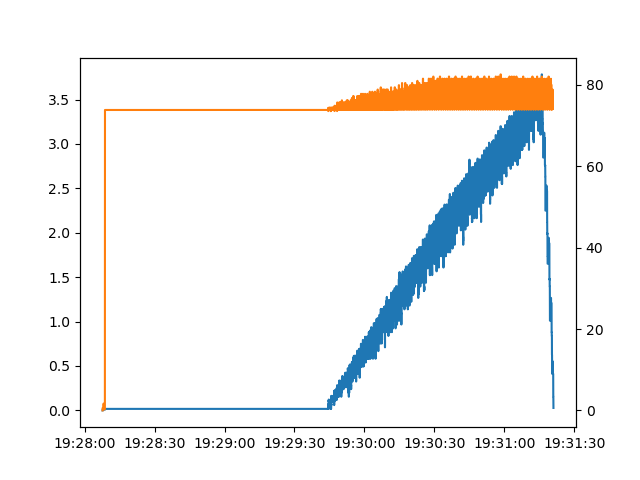

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# ax1, ax2 = ax2, ax1

gpu_plot = ax2.plot(
    [mc.timestamp for mc in gpu_memory_counters], 
    [mc.value / 1024**3 for mc in gpu_memory_counters],
    color='C1'
)
hover_annot(fig, ax2, plot_checker(gpu_plot), counters_annot_mapper(gpu_memory_counters))

cpu_plot = ax1.plot(
    [mc.timestamp for mc in cpu_memory_counters], 
    [mc.value / 1024**3 for mc in cpu_memory_counters],
    color='C0'
)
hover_annot(fig, ax1, plot_checker(cpu_plot), counters_annot_mapper(cpu_memory_counters))

plt.show()

In [53]:
gpu_span_records = collect_span_records(gpu_records)
cpu_span_records = collect_span_records(cpu_records)

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import textwrap

def span_record_annot_mapper(records, start_time, end_time):
    def mapper(details):
        record = records[details['ind'][0]]
        timestamp = start_time if record.start is None else md.date2num(record.start.timestamp)
        coord = (timestamp, record.info.pointer)
        text = textwrap.dedent(f"""\
        pointer: {hex(record.info.pointer)}
        size: {record.info.size}
        where: {record.info.where.name}
        tag: "{record.info.tag}"
        trace_id: {record.info.trace_id}
        """)
        return coord, text
    return mapper

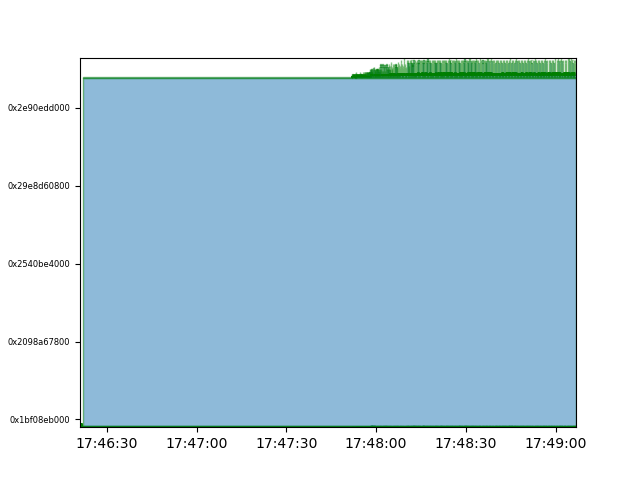

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.patches as patches
import matplotlib.collections as mc

start_time, end_time = record_measures[0]
start_time, end_time = md.date2num(start_time), md.date2num(end_time)
time_span = end_time - start_time
start_addr, end_addr = gpu_records_measures[1]
addr_span = end_addr - start_addr

fig, ax = plt.subplots()

rectangles = []
for sr in gpu_span_records:
    record_start_time = start_time if sr.start is None else md.date2num(sr.start.timestamp)
    record_end_time = end_time if sr.end is None else md.date2num(sr.end.timestamp)
    rectangle = patches.Rectangle(
        (record_start_time, sr.info.pointer), 
        record_end_time - record_start_time, 
        sr.info.size, 
    )
    rectangles.append(rectangle)
rectangles = mc.PatchCollection(rectangles, linewidth=1, edgecolor='g', alpha=0.5)

# annot = hover_annot(fig, ax, 
#                     rectangles.contains, 
#                     span_record_annot_mapper(gpu_span_records, start_time, end_time))

ax.add_collection(rectangles)
ax.set_xlim(*record_measures[0])
ax.set_ylim(start_addr, end_addr)
ax.tick_params(axis='y', labelsize=6)
ax.get_yaxis().set_major_formatter(lambda x, pos: f"0x{int(x):x}")

plt.show()

In [ ]:
# plt.close('all')